In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import pandas as pd
import numpy as np

In [37]:
header = ['userId', 'movieId', 'rating', 'timestamp' ]
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [192]:
idx2Movie = {v:k for k,v in movie2Idx.items()}

In [38]:
header = ['movieId', 'movieTitle', 'release date', 'video release date',
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
              "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']
items = pd.read_csv('./ml-100k/u.item', sep='|', encoding = "ISO-8859-1", names=header)
items.head()

,movieId,movieTitle,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [39]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

ratings = join_df(ratings, items, "movieId", "movieId")

In [41]:
ratings.head()

,userId,movieId,rating,timestamp,movieTitle,release date,video release date,IMDb URL,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [43]:
ratings['timestamp'] = ratings['timestamp']/max(ratings['timestamp'])

In [44]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [45]:
n_split = 20000
ratings_train = ratings[n_split:]
ratings_val = ratings[:n_split]
len(ratings_train), len(ratings_val)

(80000, 20000)

In [46]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1682 943 1650


In [47]:
max_rating = ratings_train['rating'].max()
min_rating = ratings_train['rating'].min()
av_rating = ratings_train['rating'].mean()
max_rating, min_rating, av_rating

(5, 1, 3.52835)

In [48]:
from keras.layers import Input, Embedding, Flatten, Dropout, Concatenate, Dense, Activation, Lambda
from keras import Model
from keras.regularizers import l2
from keras.optimizers import Adam

Using TensorFlow backend.


In [113]:
# Diferencia: las dimensiones de los Latent factors pueden ser distintos
n_latent_factors_user = 8
n_latent_factors_movie = 8

In [114]:
genre = ['Action', 'Adventure', 'Animation',
              "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']

In [163]:
genre_input = Input(shape=[len(genre)],name='genre')
timestamp_input = Input(shape=[1],name='timestamp')
movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding', embeddings_regularizer = l2(0.001))(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
# movie_vec = Dropout(0.2)(movie_vec)


user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding', embeddings_regularizer = l2(0.001))(user_input))
# user_vec = Dropout(0.2)(user_vec)


concat = Concatenate(name='Concat')([movie_vec, user_vec, timestamp_input, genre_input])
# concat = Dropout(0.2)(concat)

x = Dense(50,name='FullyConnected-1', activation='relu', kernel_regularizer=l2(0.001))(concat)
#x = Dropout(0.5)(x)
#x = Dense(50,name='FullyConnected-1', activation='relu')(concat)
#x = Dropout(0.5)(x)


## Se pueden sacar las siguientes dos lineas para no forzar a sigmoidea
x = Dense(1, activation='sigmoid',name='Activation')(x)
x = Lambda(lambda z: (max_rating - min_rating) * z + min_rating)(x)
##

model = Model([user_input, movie_input, timestamp_input, genre_input], x)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 8)         7552        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [164]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [165]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [166]:
adam = Adam(lr=0.001)
model.compile(optimizer=adam,loss= 'mean_squared_error', metrics=[root_mean_squared_error])

In [167]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True, monitor='val_root_mean_squared_error')

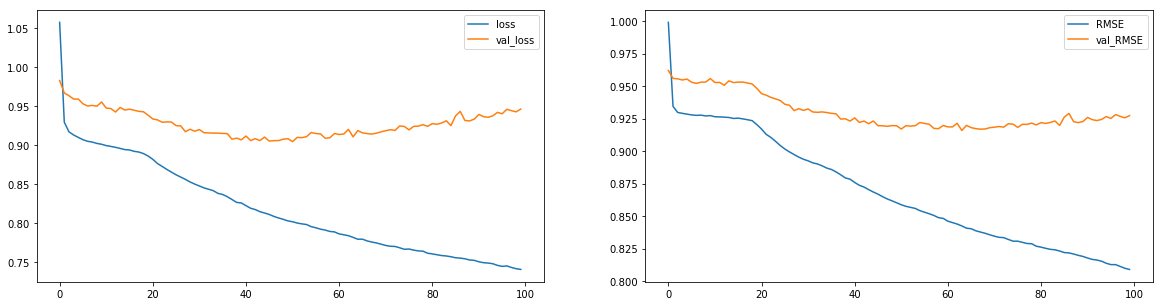


Epoch 00100: val_root_mean_squared_error did not improve from 0.91584


In [168]:
history = model.fit([ratings_train.userId, ratings_train.movieId, ratings_train.timestamp, ratings_train[genre]], 
                    ratings_train.rating, 
                    validation_data=([ratings_val.userId, ratings_val.movieId, ratings_val.timestamp, ratings_val[genre]], ratings_val.rating), 
                    batch_size = 160,
                    callbacks = [plot_losses, checkpointer],
                    epochs=100, verbose=2)

In [169]:
model.evaluate([ratings_val.userId, ratings_val.movieId, ratings_val.timestamp, ratings_val[genre]], ratings_val.rating)

20000/20000 [==============================] - 0s 19us/step


[0.9462206999778747, 0.9195427624702454]

In [170]:
model.load_weights('weights.hdf5')
model.evaluate([ratings_val.userId, ratings_val.movieId, ratings_val.timestamp, ratings_val[genre]], ratings_val.rating)

20000/20000 [==============================] - 0s 20us/step


[0.9105462028503418, 0.9087436557769776]

# Embeddings

In [172]:
movie_embeddings_layer = model.layers[2]
user_embeddings_layer = model.layers[3]

In [177]:
movie_embeddings_layer.name, user_embeddings_layer.name

('Movie-Embedding', 'User-Embedding')

In [178]:
movie_embeddings_matrix = movie_embeddings_layer.get_weights()[0]
user_embeddings_matrix = user_embeddings_layer.get_weights()[0]
movie_embeddings_matrix.shape, user_embeddings_matrix.shape

((1683, 8), (944, 8))

In [187]:
model_test_emb = Model([movie_input], [movie_embedding])

In [236]:
index = 424 #6
movie_embed = model_test_emb.predict([index])
items.loc[idx2Movie[index]].movieTitle

'Lion King, The (1994)'

In [237]:
from sklearn.neighbors import NearestNeighbors

In [238]:
nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(movie_embeddings_matrix)

In [239]:
neighbors = nbrs.kneighbors([movie_embeddings_matrix[index]])

In [240]:
neighbors

(array([[0.        , 0.02538699, 0.02607101, 0.03320599, 0.03362662,
         0.0354948 , 0.0393489 , 0.04095584, 0.04397959, 0.04919779]],
       dtype=float32),
 array([[ 424,  903,   92,  940,  638, 1332,  864, 1385, 1395,  267]]))

In [241]:
for idx in neighbors[1][0]:
    print(items.loc[idx2Movie[idx]].movieTitle)

Lion King, The (1994)
Traveller (1997)
Cat on a Hot Tin Roof (1958)
Chinatown (1974)
Phat Beach (1996)
Stefano Quantestorie (1993)
Steel (1997)
Love and Death on Long Island (1997)
Somebody to Love (1994)
Star Maker, The (Uomo delle stelle, L') (1995)
